In [335]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from sklearn.neighbors import KDTree

## RRT Implementation by Kristian W. M. Gulaker
## First segment is initialization of objective parameters

# Parameters for grid world
x_max = 1000
x_min = 0
y_max = 1000
y_min = 0

# Initial state for robot
x_0 = 0
y_0 = 0
rad_robot = 25

# Goal state for robot
x_f = 800
y_f = 940
rad_finish = 25

# First obstacle
x_obst_1 = 500
y_obst_1 = 450
rad_obst_1 = 100

# Second obstacle
x_obst_2 = 400
y_obst_2 = 700
rad_obst_2 = 100

obstacles = np.array([[x_obst_1,y_obst_1,rad_obst_1],[x_obst_2,y_obst_2,rad_obst_2]])

In [379]:
## Definition of RRT algorithm and relevant functions
#  For this implementation we think of a vertex as [x,y] and an edge as [vertex_1, vertex_2]

# Gets random point in grid
def getRandomPosition(V,step):
    # Generate random location
    random_x = random.randint(x_min,x_max)
    random_y = random.randint(y_min,y_max)
    new_random_point = [random_x,random_y]
    
    # Check if nearest vertex is within stepsize.
    neighbor = getNearestVertex(V,new_random_point)
    dist = math.dist(neighbor,new_random_point)
    
    if(dist <= step):
        # Return immediately if random point is within step
        return new_random_point
    else:
        ratio = step/dist
        tapered_x = (1-ratio)*neighbor[0] + ratio*random_x
        tapered_y = (1-ratio)*neighbor[1] + ratio*random_y
        return [tapered_x,tapered_y]

# Finds minimal distance from line to point 
# https://www.geeksforgeeks.org/minimum-distance-from-a-point-to-the-line-segment-using-vectors/?fbclid=IwAR2fJ3xL1udjsIuqu9rLl_T3_tkVoIvb-XYAkGlDvmLkY5E4XNhCx8LDDIk
def minDistance(A, B, E) :
    AB = [None, None];
    AB[0] = B[0] - A[0];
    AB[1] = B[1] - A[1];
    # vector BP
    BE = [None, None];
    BE[0] = E[0] - B[0];
    BE[1] = E[1] - B[1];
    # vector AP
    AE = [None, None];
    AE[0] = E[0] - A[0];
    AE[1] = E[1] - A[1];
    # Variables to store dot product
    # Calculating the dot product
    AB_BE = AB[0] * BE[0] + AB[1] * BE[1];
    AB_AE = AB[0] * AE[0] + AB[1] * AE[1];
    # Minimum distance from
    # point E to the line segment
    reqAns = 0;
    # Case 1
    if (AB_BE > 0) :
        # Finding the magnitude
        y = E[1] - B[1];
        x = E[0] - B[0];
        reqAns = math.sqrt(x * x + y * y);
    # Case 2
    elif (AB_AE < 0) :
        y = E[1] - A[1];
        x = E[0] - A[0];
        reqAns = math.sqrt(x * x + y * y);
    # Case 3
    else:
        # Finding the perpendicular distance
        x1 = AB[0];
        y1 = AB[1];
        x2 = AE[0];
        y2 = AE[1];
        mod = math.sqrt(x1 * x1 + y1 * y1);
        reqAns = abs(x1 * y2 - y1 * x2) / mod;
    return reqAns;


# Returns true/false based on if a point hits an obstacle
def hitsObstacles(point_new, point_nearest, obstacles):
    hitsObstacles = False
    # We draw a line between new and nearest point, and check if line intersects one of the obstacles.
    # We do this by checking if the nearest distance in the line lies within radius of obstacle.
    
    for obstacle in obstacles:
        distance = minDistance(point_nearest, point_new, [obstacle[0],obstacle[1]])
        if(distance <= obstacle[2]):
            hitsObstacles = True
    
    return hitsObstacles
    

# Gets nearest vertex in graph based on a new point
def getNearestVertex(vertices,new_point):
    # We use KDTree's Nearest Neighbor algorithm to find the closest vertex.
    tree = KDTree(vertices)
    dist, ind = tree.query([new_point], k=1)
    return vertices[ind[0][0]]
    

# Checks if a point meets goal target
def meetsGoal(point,goal,max_dist):
    dist = math.dist(point,goal)
    if(dist < max_dist):
        return dist,True
    else:
        return dist,False
    
# Returns parent node connection of child node in given graph
def getParent(V,E,child):
    parent = []
    for edge in E:
        if(edge[2] == child[0] and edge[3] == child[1]):
            parent = edge
    return parent

# Returns path from end to start node of a given graph
def getPath(V,E):
    root = False
    curr_child = V[len(V) - 1] # End node
    path = np.empty((0,4),int) # list of edges from goal to root
    
    while(not root):
        curr_parent = getParent(V,E,curr_child)
        if(len(curr_parent) == 0): #Case 1: we have arrived at root node
            root = True
            continue
        else: #Case 2: Exists more parent nodes, therefore not root
            path = np.append(path,([curr_parent]),axis=0)
            curr_child = [curr_parent[0], curr_parent[1]]
            
    return path
    

def RRT(init,goal,limit,step,max_dist):
    
    timer = 0
    initiated = False    
    V = np.empty((0,2),int) #initial vertice list
    E = np.empty((0,4),int) #initial edge list
    V = np.append(V, np.array([init]),axis=0)
    
    while(timer < limit):
        timer = timer+1
        point_new = getRandomPosition(V,step) # Find random point
        if(not initiated): #Case: first iteration only has one point
            point_nearest = V[0]
            
        else: #Case: multiple points to choose from
            point_nearest = getNearestVertex(V,point_new) # Finds nearest existing vertex to new point
        if(hitsObstacles(point_new, point_nearest,obstacles) == True): # Check if point is feasible
            continue
        
        initiated = True
        V = np.append(V,np.array([point_new]),axis=0) # Adds new vertex to graph
        
        new_edge = np.array([point_nearest,point_new]).reshape(1,-1) # New edge between parent and child
        E = np.append(E,(new_edge),axis=0)
        
        dist,goalMet = meetsGoal(point_new,goal,max_dist)
            
        if(goalMet):
            print("goal met")
            return V,E
        
    return V,E
        

In [380]:
V,E = RRT([x_0,y_0],[x_f,y_f],1000,50,50)

goal met


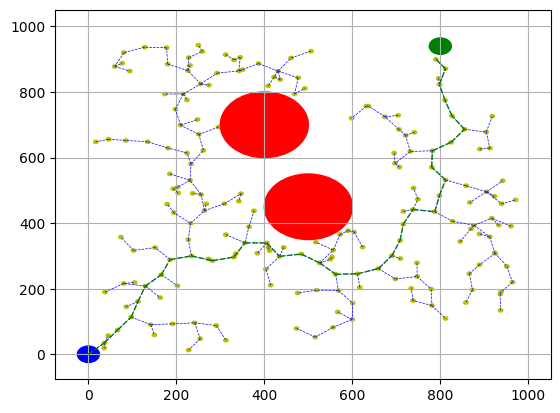

In [383]:
# Getting all vertices
vertices = []
for vertex in V:
    vertices.append(plt.Circle((vertex[0], vertex[1]), 5, color='y'))
    
for circle in vertices:
    plt.gca().add_patch(circle)

# Getting all edges
edges = []
for edge in E:
    x_values = [edge[0], edge[2]]
    y_values = [edge[1], edge[3]]
    plt.plot(x_values, y_values, 'b', linestyle="--", linewidth=0.5)

# Getting path
path = getPath(V,E)
for edge in path:
    x_values = [edge[0], edge[2]]
    y_values = [edge[1], edge[3]]
    plt.plot(x_values, y_values, 'g', linestyle="--", linewidth=1)

#Plotting world
plt.plot(x_max,y_max)

#Plotting obstacles
obstacle_1 = plt.Circle((x_obst_1, y_obst_1), rad_obst_1, color='r')
obstacle_2 = plt.Circle((x_obst_2, y_obst_2), rad_obst_2, color='r')

#Plotting initial state and goal
initial = plt.Circle((x_0, y_0), rad_robot, color='b')
goal = plt.Circle((x_f,y_f), rad_finish, color='g')

#Adding to plots and showing
plt.gca().add_patch(initial)
plt.gca().add_patch(goal)
plt.gca().add_patch(obstacle_1)
plt.gca().add_patch(obstacle_2)
plt.plot()
plt.grid()
plt.show()